In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import scale
import scipy.ndimage

In [2]:
'''Data was the same data that was used for the notMNIST lesson'''

labels = np.load("../data/notMNIST/train_labels.npy")
train_images = np.load("../data/notMNIST/train_images.npy")
test_images = np.load("../data/notMNIST/test_images.npy")
label_names = np.array(['A','B','C','D','E','F','G','H','I','J'])

In [3]:
print("There are "+str(train_images.shape[0]) + " images in the dataset")
print("The dimensions of each image are "+str(train_images.shape[1])+" by "+ str(train_images.shape[2]))
print(test_images.shape)

There are 100 images in the dataset
The dimensions of each image are 28 by 28
(100, 28, 28)


In [4]:
def get_image_and_label(image_number):
    plt.matshow(train_images[image_number], cmap=plt.cm.gray)
    print(label_names[labels[image_number]])

def show_image(image):
        plt.matshow(image, cmap=plt.cm.gray)

Origional image
Downscaled by 1/2
Upscaled back to origional


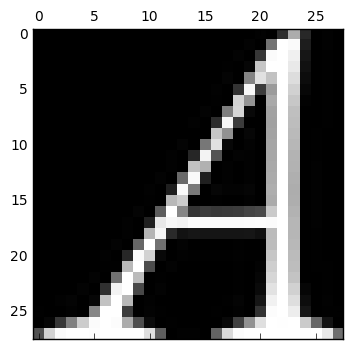

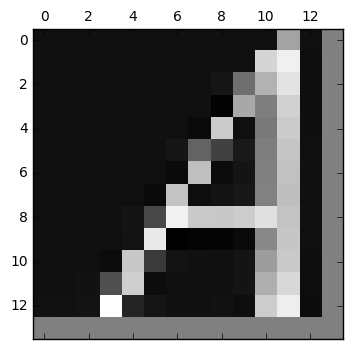

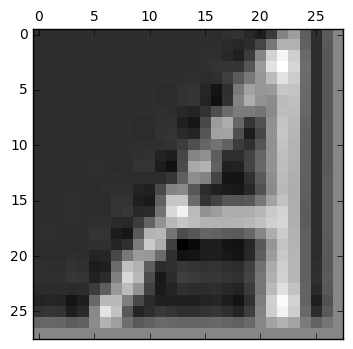

In [14]:
'''
This code shows what the effect of these scaling functions is. Tensorflow actually has image scaling built in as well. 
'''

print("Origional image")
show_image(train_images[0])
print("Downscaled by 1/2")
show_image(scipy.ndimage.zoom(train_images[0],.5))
print("Upscaled back to origional")
show_image(scipy.ndimage.zoom(scipy.ndimage.zoom(train_images[0],.5),2))


In [6]:
'''This code creates downscaled datasets that can be used for training. 

'''
downscaled_train = np.array([scipy.ndimage.zoom(i,.5) for i in train_images])
downscaled_test = np.array([scipy.ndimage.zoom(i,.5) for i in test_images])
print(downscaled_train.shape)
print(train_images.shape)

(100, 14, 14)
(100, 28, 28)


In [7]:
'''
Model 1

Uses single layer NN. No convolution. 
'''

small_train = tf.placeholder('float32', shape = [None, 14, 14])
large_train = tf.placeholder('float32', shape = [None, 28, 28])

small_train_flattened = tf.reshape(small_train,[-1,14*14])
large_train_flattened = tf.reshape(large_train,[-1,28*28])

w = tf.Variable(tf.truncated_normal([14*14, 28*28]))
b = tf.Variable(tf.truncated_normal([1,28*28]))

multiplied = tf.matmul(small_train_flattened,w)+b

MSE = tf.reduce_mean(tf.square(multiplied - large_train_flattened))

pred = tf.reshape(multiplied,[-1,28,28])

optimizer = tf.train.AdamOptimizer().minimize(MSE)

init = tf.initialize_all_variables()

In [8]:
sess = tf.Session()
sess.run(init)

In [9]:
MAXSTEPS = 10000
for step in range(MAXSTEPS):
    (_,mse) = sess.run([optimizer,MSE],feed_dict = {small_train: downscaled_train, large_train: train_images})
    if (step % 1000)==0:
        test_mse = sess.run(MSE, feed_dict = {small_train: downscaled_test, large_train: test_images})
        print('step = %-5d MSE = %-10f Test MSE = %-10f' % (step,mse,test_mse))
print("Done!")

step = 0     MSE = 28.540491  Test MSE = 28.183443 
step = 1000  MSE = 1.544899   Test MSE = 4.786267  
step = 2000  MSE = 0.426738   Test MSE = 3.451692  
step = 3000  MSE = 0.158068   Test MSE = 2.932705  
step = 4000  MSE = 0.064531   Test MSE = 2.662187  
step = 5000  MSE = 0.026497   Test MSE = 2.505931  
step = 6000  MSE = 0.010334   Test MSE = 2.417452  
step = 7000  MSE = 0.003673   Test MSE = 2.373388  
step = 8000  MSE = 0.001164   Test MSE = 2.356119  
step = 9000  MSE = 0.000342   Test MSE = 2.351744  
Done!


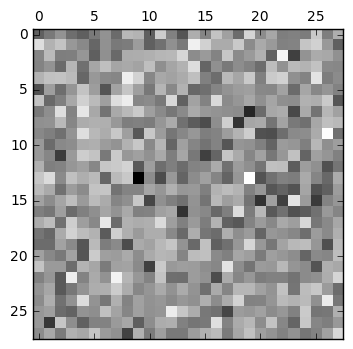

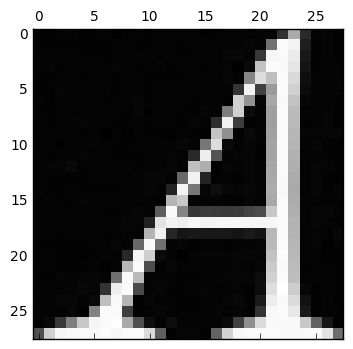

In [13]:
'''
Example of how terribly overfitted the model is at this point


'''

test_pred = sess.run(pred, feed_dict = {small_train: downscaled_test})
train_pred = sess.run(pred, feed_dict = {small_train: downscaled_train})
show_image(test_pred[0])
show_image(train_pred[0])

In [33]:
'''
Model 2

Uses single layer NN. No convolution. 
'''

small_train = tf.placeholder('float32', shape = [None, 14, 14])
large_train = tf.placeholder('float32', shape = [None, 28, 28])

small_train_flattened = tf.reshape(small_train,[-1,14*14])
large_train_flattened = tf.reshape(large_train,[-1,28*28])

w = tf.Variable(tf.truncated_normal([14*14, 28*28]))
b = tf.Variable(tf.truncated_normal([1,28*28]))

multiplied = tf.matmul(small_train_flattened,w)+b+tf.reshape(tf.image.resize_images(small_train,28,28),[-1,28*28])

MSE = tf.reduce_mean(tf.square(multiplied - large_train_flattened))

pred = tf.reshape(multiplied,[-1,28,28])

optimizer = tf.train.AdamOptimizer().minimize(MSE)

init = tf.initialize_all_variables()

In [34]:
#multiplied = tf.matmul(small_train_flattened,w)+b + tf.image.resize_bilinear

In [35]:
#multiplied = tf.matmul(small_train_flattened,w)+b + tf.image.resize_images

In [36]:
sess = tf.Session()
sess.run(init)

In [37]:
MAXSTEPS = 10000
for step in range(MAXSTEPS):
    (_,mse) = sess.run([optimizer,MSE],feed_dict = {small_train: downscaled_train, large_train: train_images})
    if (step % 1000)==0:
        test_mse = sess.run(MSE, feed_dict = {small_train: downscaled_test, large_train: test_images})
        print('step = %-5d MSE = %-10f Test MSE = %-10f' % (step,mse,test_mse))
print("Done!")

InvalidArgumentError: Incompatible shapes: [100,784] vs. [14,784]
	 [[Node: gradients_6/add_16_grad/BroadcastGradientArgs = BroadcastGradientArgs[_device="/job:localhost/replica:0/task:0/cpu:0"](gradients_6/add_16_grad/Shape, gradients_6/add_16_grad/Shape_1)]]
Caused by op 'gradients_6/add_16_grad/BroadcastGradientArgs', defined at:
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-2171d8877e44>", line 22, in <module>
    optimizer = tf.train.AdamOptimizer().minimize(MSE)
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/training/optimizer.py", line 196, in minimize
    grad_loss=grad_loss)
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/training/optimizer.py", line 253, in compute_gradients
    colocate_gradients_with_ops=colocate_gradients_with_ops)
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/gradients.py", line 478, in gradients
    in_grads = _AsList(grad_fn(op, *out_grads))
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py", line 499, in _AddGrad
    rx, ry = gen_array_ops._broadcast_gradient_args(sx, sy)
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 366, in _broadcast_gradient_args
    name=name)
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2310, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1232, in __init__
    self._traceback = _extract_stack()

...which was originally created as op 'add_16', defined at:
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
[elided 18 identical lines from previous traceback]
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-2171d8877e44>", line 16, in <module>
    multiplied = tf.matmul(small_train_flattened,w)+b+tf.reshape(tf.image.resize_images(small_train,28,28),[-1,28*28])
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 754, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 70, in add
    result = _op_def_lib.apply_op("Add", x=x, y=y, name=name)
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2310, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/peter/.conda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1232, in __init__
    self._traceback = _extract_stack()
